Comparativa entre simulación (sin defectos) y pieza real (puede tener deefctos)

In [ ]:
import os
import numpy as np
import cv2
import tifffile
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from scipy.ndimage import label as cc_label, binary_opening, distance_transform_edt, median_filter, binary_erosion
import matplotlib.pyplot as plt

def carga_y_preprocesamiento(folder, img_size=(512, 512), depth_limit=None):
    """
    Lee imágenes 2D desde 'folder', recorta 10% de los bordes, redimensiona a img_size,
    normaliza a [0,1] y devuelve un tensor [C, D, H, W].

    - folder: carpeta con slices (orden alfabético).
    - img_size: (W, H) destino por slice.
    - depth_limit: nº máx. de slices (None = todos).
    """
    exts = {".tif", ".tiff", ".png", ".jpg", ".jpeg", ".bmp"}
    files = sorted([f for f in os.listdir(folder) if os.path.splitext(f.lower())[1] in exts])
    if depth_limit is not None:
        files = files[:depth_limit]
    if len(files) == 0:
        raise ValueError(f"No se encontraron imágenes válidas en: {folder}")

    stack = []
    for file in files:
        path = os.path.join(folder, file)
        img = tifffile.imread(path)  # (H,W) o (H,W,C)

        # A RGB si es gris
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)  # (H,W,3)

        # Si es RGBA (4 canales) quitar alpha
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[:, :, :3]

        H, W = img.shape[:2]

        # --- recorte 10% en cada lado ---
        t = b = l = r = 0.10
        top    = int(round(H * t))
        bottom = int(round(H * (1 - b)))
        left   = int(round(W * l))
        right  = int(round(W * (1 - r)))
        # clamps de seguridad
        top    = max(0, min(top, H-2))
        bottom = max(top+1, min(bottom, H))
        left   = max(0, min(left, W-2))
        right  = max(left+1, min(right, W))
        img = img[top:bottom, left:right, :]

        # Resize (cv2 usa (W,H))
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

        # Normalizar a [0,1]
        img = img.astype("float32")
        if img.max() > 1.0:
            img = img / 255.0

        # (H,W,C) -> (C,H,W)
        img = np.transpose(img, (2, 0, 1))
        stack.append(img)

    volume = np.stack(stack, axis=1)  # (C, D, H, W)
    tensor = torch.tensor(volume, dtype=torch.float32)
    return tensor


In [ ]:
Simulacion_nudo_1 = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_1", depth_limit=None)
Simulacion_nudo_2 = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_2", depth_limit=None)
Simulacion_nudo_3 = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_3", depth_limit=None)
Simulacion_nudo_4 = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_4", depth_limit=None)
Simulacion_nudo_5 = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_5", depth_limit=None)
Simulacion_nudo_6 = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_6", depth_limit=None)
Simulacion_nudo_7  = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_7", depth_limit=None)
Simulacion_nudo_8  = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_8", depth_limit=None)
Simulacion_nudo_9  = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\No supervisado\Simulacion\Nudo_9", depth_limit=None)


no_anillo = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Iker\Scripts\AA_Pueba_anillos\Prueba_Anillos\Probeta_no_anillo\No defectos", depth_limit=None)
no_anillo_defectos_imagenes = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Pureba_Anillos\Probeta_no_anillo\imgs", depth_limit=None)
no_anillo_defectos_masks    = carga_y_preprocesamiento(r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Pureba_Anillos\Probeta_no_anillo\masks", depth_limit=None)

# Añadir dimensión de batch -> (1, C, D, H, W)
Simulacion_nudo_1 = Simulacion_nudo_1.unsqueeze(0)
Simulacion_nudo_2 = Simulacion_nudo_2.unsqueeze(0)
Simulacion_nudo_3 = Simulacion_nudo_3.unsqueeze(0)
Simulacion_nudo_4 = Simulacion_nudo_4.unsqueeze(0)
Simulacion_nudo_5 = Simulacion_nudo_5.unsqueeze(0)
Simulacion_nudo_6 = Simulacion_nudo_6.unsqueeze(0)
Simulacion_nudo_7 = Simulacion_nudo_7.unsqueeze(0)
Simulacion_nudo_8 = Simulacion_nudo_8.unsqueeze(0)
Simulacion_nudo_9 = Simulacion_nudo_9.unsqueeze(0)
Simulacion_nudo_10 = no_anillo.unsqueeze(0)

no_anillo_defectos_imagenes = no_anillo_defectos_imagenes.unsqueeze(0)
no_anillo_defectos_masks    = no_anillo_defectos_masks.unsqueeze(0)

print(no_anillo_defectos_imagenes.shape)
print(no_anillo_defectos_masks.shape)

torch.Size([1, 3, 10, 512, 512])
torch.Size([1, 3, 10, 512, 512])


In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# VAE 2D 

class VAE2D(nn.Module):
    def __init__(self, in_ch=3, latent_dim=128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1), nn.ReLU(inplace=True),
        )
        self.flatten_dim = 256 * (512//16) * (512//16)
        self.mu     = nn.Linear(self.flatten_dim, latent_dim)
        self.logvar = nn.Linear(self.flatten_dim, latent_dim)
        self.dec_fc = nn.Linear(latent_dim, self.flatten_dim)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, in_ch, 4, 2, 1), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(x.size(0), -1)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(z.size(0), 256, 512//16, 512//16)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar):
    rec_loss = F.mse_loss(recon, x, reduction='sum') / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return rec_loss + kl, rec_loss, kl


# Dataset: slices 2D de múltiples volúmenes

class VolSlicesDataset(Dataset):
    """
    vols: tensor [N, C, D, H, W] con todos los volúmenes de entrenamiento.
    Produce muestras 2D [C, H, W] iterando (n, d).
    """
    def __init__(self, vols):
        assert vols.ndim == 5, f"Esperaba [N,C,D,H,W], recibí {tuple(vols.shape)}"
        self.vols = vols
        self.N, self.C, self.D, self.H, self.W = vols.shape
        # Si cada volumen tiene D distinto, usa el mínimo común:
        # self.D = min(v.shape[2] for v in vols)  # si fuera lista de tensores
        self.index = [(n, d) for n in range(self.N) for d in range(self.D)]

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        n, d = self.index[i]
        x = self.vols[n, :, d, :, :]   # [C,H,W]
        return x

# Preparamos datos y entrenamiento
# simulaciones: [N, 3, 100, 512, 512]

simulaciones=torch.cat([Simulacion_nudo_1 , Simulacion_nudo_2, Simulacion_nudo_3, Simulacion_nudo_4, Simulacion_nudo_5, Simulacion_nudo_6, Simulacion_nudo_10], dim=0)
    
assert simulaciones.ndim == 5 and simulaciones.shape[1] == 3, "simulaciones debe ser [N,3,D,512,512]"

train_dataset = VolSlicesDataset(simulaciones)  # usa TODOS los volúmenes y TODOS los slices
train_loader  = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

val_dataset = VolSlicesDataset(no_anillo_defectos_imagenes)  # usa TODOS los volúmenes y TODOS los slices
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

vae = VAE2D(in_ch=3, latent_dim=128).to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
CKPT = "vae2d_train.pt"


In [6]:


EPOCHS = 15

vae.train()
for ep in range(1, EPOCHS+1):
    total_loss = total_rec = total_kl = 0.0
    for x in train_loader:
        # x: [B, C, H, W]
        x = x.to(DEVICE, non_blocking=True)
        opt.zero_grad()
        recon, mu, logvar = vae(x)
        loss, rec, kl = vae_loss(recon, x, mu, logvar)
        loss.backward()
        opt.step()
        total_loss += loss.item()
        total_rec  += rec.item()
        total_kl   += kl.item()
    n_batches = len(train_loader)
    print(f"[{ep}/{EPOCHS}] Loss={total_loss/n_batches:.4f} | Rec={total_rec/n_batches:.4f} | KL={total_kl/n_batches:.4f}")

torch.save(vae.state_dict(), CKPT)
print("Modelo guardado en", CKPT)

[1/15] Loss=44308.4315 | Rec=29733.1039 | KL=14575.3276
[2/15] Loss=19322.6093 | Rec=17808.7842 | KL=1513.8252
[3/15] Loss=5601.8159 | Rec=5337.1377 | KL=264.6782
[4/15] Loss=2754.1820 | Rec=2566.0997 | KL=188.0823
[5/15] Loss=1457.5254 | Rec=1276.2132 | KL=181.3122
[6/15] Loss=853.3738 | Rec=669.7117 | KL=183.6621
[7/15] Loss=698.9114 | Rec=525.6547 | KL=173.2567
[8/15] Loss=654.4457 | Rec=474.4514 | KL=179.9943
[9/15] Loss=616.2690 | Rec=443.9628 | KL=172.3062
[10/15] Loss=537.6099 | Rec=376.6715 | KL=160.9384
[11/15] Loss=690.6359 | Rec=478.1037 | KL=212.5323
[12/15] Loss=584.8717 | Rec=387.2458 | KL=197.6259
[13/15] Loss=527.2271 | Rec=341.1396 | KL=186.0875
[14/15] Loss=416.1999 | Rec=277.7886 | KL=138.4113
[15/15] Loss=416.9893 | Rec=283.1731 | KL=133.8162
Modelo guardado en vae2d_train.pt


Usando umbral fijo (en FG) = 0.15
Métricas @thr=0.15: Dice=0.8722 | IoU=0.7734 | Prec=0.9596 | Rec=0.7994


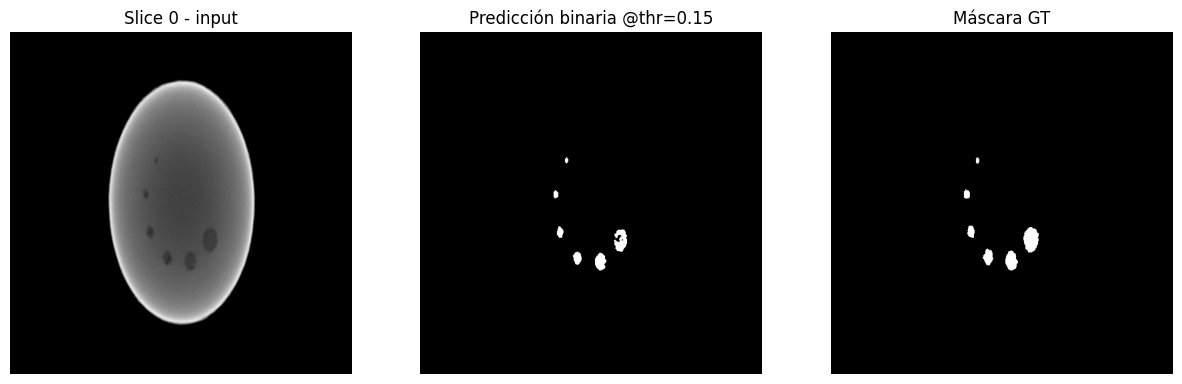

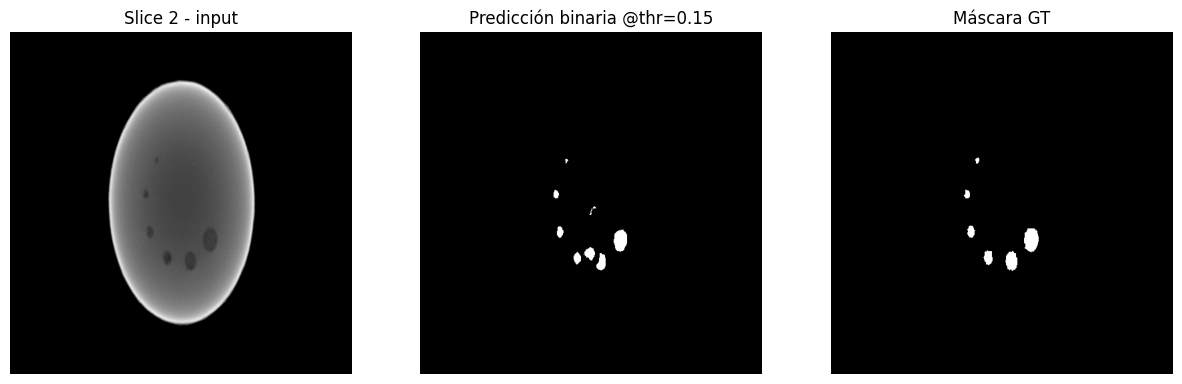

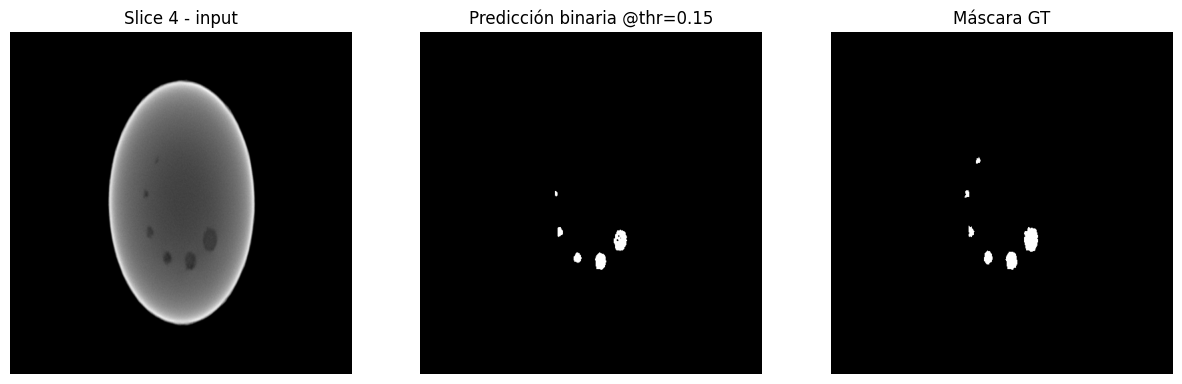

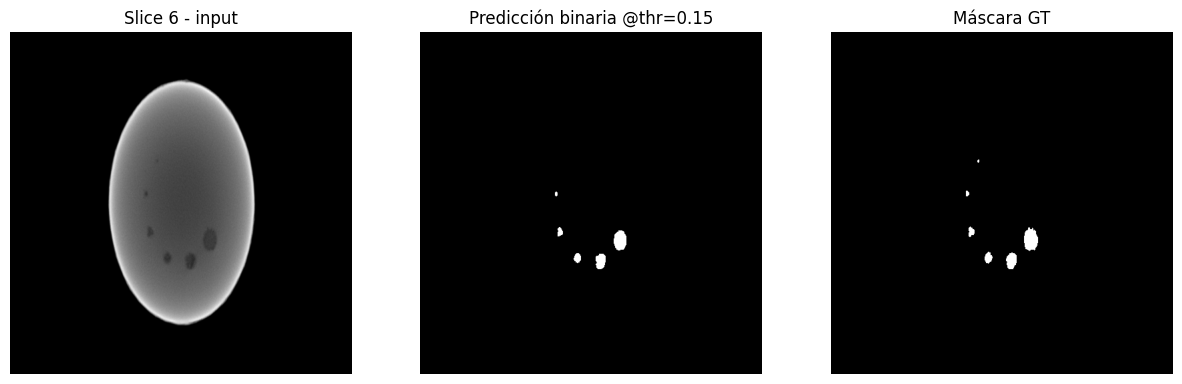

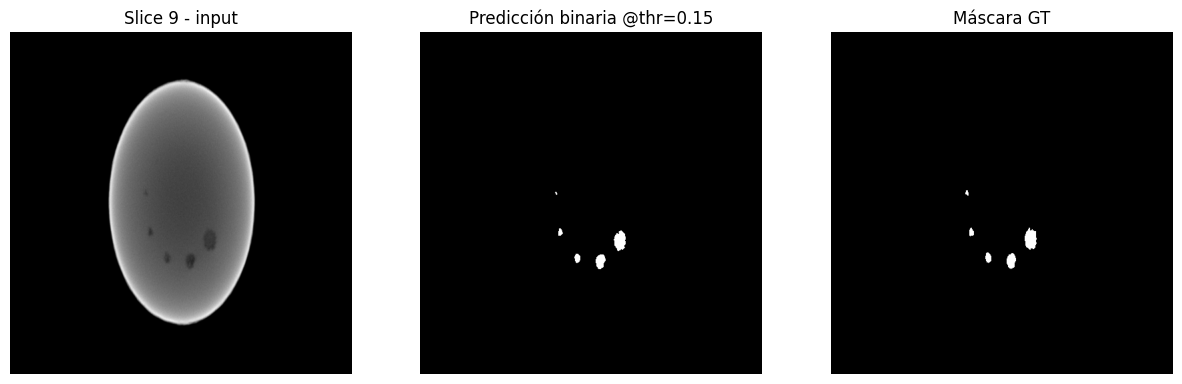

In [ ]:
D, H, W = score_map.shape[0], score_map.shape[2], score_map.shape[3]

# Visualización de las máscaras y prediccines

gray = X_val.mean(dim=0).cpu().numpy()  # [D,H,W] en [0,1]
fg_mask_np = np.zeros_like(gray, dtype=bool)

# parámetros de FG
int_thr      = 0.02     # umbral de intensidad para separar pieza del fondo
border_px    = 19        # ancho (en píxeles) del anillo a recortar desde el borde (ajusta aquí)
min_comp_pix = 500      # tamaño mínimo para quedarse con la mayor componente

for d in range(D):
    g = gray[d]
    m = g > int_thr

    # quedarnos con la mayor componente
    lab, n = cc_label(m.astype(np.uint8), structure=np.ones((3,3)))
    if n > 0:
        areas = [(lab==k).sum() for k in range(1, n+1)]
        kmax = np.argmax(areas) + 1
        m = (lab == kmax)

    # apertura ligera para quitar motas internas
    m = binary_opening(m, structure=np.ones((3,3)))

    # quitar SOLO un anillo de border_px desde el borde de la pieza
    # (distancia a fondo dentro de la máscara)
    dist = distance_transform_edt(m)
    m = m & (dist >= border_px)

    # seguridad: si por error se queda vacía, no aplicamos anillo
    if m.sum() < min_comp_pix:
        m = (lab == kmax)

    fg_mask_np[d] = m

fg_mask = torch.from_numpy(fg_mask_np).unsqueeze(1).float()   # [D,1,H,W]

# ---------- 2) NORMALIZACIÓN dentro del FG ----------
# score restringido al FG
score = (score_map * fg_mask)  # [D,1,H,W]
# min/max por slice SOLO en voxels de FG
# para evitar NaNs, rellenamos con 0 fuera de FG y computamos min/max en FG vía máscaras
score_np = score.cpu().numpy()
fg_np    = fg_mask.cpu().numpy().astype(bool)

score_norm = np.zeros_like(score_np, dtype=np.float32)
for d in range(D):
    s  = score_np[d,0]
    fm = fg_np[d,0]
    if fm.sum() == 0:
        score_norm[d,0] = 0.0
        continue
    s_fg = s[fm]
    smin, smax = np.min(s_fg), np.max(s_fg)
    if smax <= smin + 1e-8:
        score_norm[d,0] = 0.0
    else:
        tmp = (s - smin) / (smax - smin + 1e-8)
        tmp[~fm] = 0.0
        # filtro mediana suave para quitar salpicado (opcional)
        tmp = median_filter(tmp, size=3)
        score_norm[d,0] = tmp

score_norm = torch.from_numpy(score_norm)

# UNMBRAL PARA DETERMINAR DEFECTO

thr = 0.15  # VALOR DEL UMBRAL
print(f"Usando umbral fijo (en FG) = {thr}")
pred_fg = (score_norm > thr).float() * fg_mask  # [D,1,H,W]


min_pix = 5  # Mínimo número de píxeles para considerar defecto
pred_np = pred_fg.cpu().numpy().astype(bool)
for d in range(D):
    lab, n = cc_label(pred_np[d,0].astype(np.uint8), structure=np.ones((3,3)))
    keep = np.zeros((H,W), dtype=bool)
    for k in range(1, n+1):
        comp = (lab==k)
        if comp.sum() >= min_pix:
            keep |= comp
    pred_np[d,0] = keep
pred_clean = torch.from_numpy(pred_np).float()

# ---------- 5) Métricas ----------

GT_bin = (GT_val > 0.5).float().permute(1,0,2,3)
def seg_metrics(pred, gt, eps=1e-7):
    tp = (pred*gt).sum()
    fp = (pred*(1-gt)).sum()
    fn = ((1-pred)*gt).sum()
    dice = (2*tp+eps)/(2*tp+fp+fn+eps)
    iou  = (tp+eps)/(tp+fp+fn+eps)
    prec = (tp+eps)/(tp+fp+eps)
    rec  = (tp+eps)/(tp+fn+eps)
    return float(dice), float(iou), float(prec), float(rec)

GT_bin = 1 - GT_bin

d,i,pv,r = seg_metrics(pred_clean, GT_bin.float())
print(f"Métricas @thr={thr}: Dice={d:.4f} | IoU={i:.4f} | Prec={pv:.4f} | Rec={r:.4f}")

# ---------- 6) Visualización rápida ----------
def edges2d(mask2d_bool):
    return mask2d_bool ^ binary_erosion(mask2d_bool, structure=np.ones((3,3)))

indices = np.linspace(0, D-1, 5, dtype=int)

for idx in indices:
    x_rgb = X_val[:, idx].permute(1,2,0).cpu().numpy()
    pb = pred_clean[idx,0].cpu().numpy().astype(bool)   # pred binaria
    gm = GT_bin[idx,0].cpu().numpy().astype(bool)       # GT

    plt.figure(figsize=(15,5))
    # Panel 1: input
    plt.subplot(1,3,1)
    plt.imshow(x_rgb)
    plt.title(f"Slice {idx} - input")
    plt.axis('off')

    # Panel 2: máscara predicha (binaria)
    plt.subplot(1,3,2)
    plt.imshow(pb, cmap='gray')
    plt.title(f"Predicción binaria @thr={thr}")
    plt.axis('off')

    # Panel 3: máscara ground truth
    plt.subplot(1,3,3)
    plt.imshow(gm, cmap='gray')
    plt.title("Máscara GT")
    plt.axis('off')

    plt.show()

In [ ]:
# Métricas de segmentación


def instances_from_mask_2d(mask, min_pix=10):
    lab, n = cc_label(mask.astype(np.uint8), structure=np.ones((3,3)))
    insts = []
    for k in range(1, n+1):
        m = (lab == k)
        if m.sum() >= min_pix:
            insts.append(m)
    return insts

def iou2d(a, b):
    inter = np.logical_and(a,b).sum()
    union = np.logical_or(a,b).sum()
    return inter/union if union>0 else 0.0

# ---------- Construir instancias ----------
D = pred_clean.shape[0]
GT_insts, Pred_insts, Pred_scores = [], [], []

for d in range(D):
    gt_mask = GT_bin[d,0].cpu().numpy().astype(bool)
    pd_mask = pred_clean[d,0].cpu().numpy().astype(bool)

    gt_list = instances_from_mask_2d(gt_mask, min_pix=10)
    pd_list = instances_from_mask_2d(pd_mask, min_pix=10)

    GT_insts.append(gt_list)
    Pred_insts.append(pd_list)
    # Como las predicciones ya son binarias, asignamos score = 1.0 a todas
    Pred_scores.append([1.0]*len(pd_list))

# ---------- Evaluación COCO-like ----------
iou_thrs = np.arange(0.50, 0.96, 0.05)
aps_thr = []

for thr in iou_thrs:
    all_preds = []
    for d in range(D):
        for i, sc in enumerate(Pred_scores[d]):
            all_preds.append((sc, d, i))
    if len(all_preds) == 0:
        aps_thr.append(0.0)
        continue

    all_preds.sort(key=lambda x: -x[0])  # trivial, todos 1.0

    matched = [set() for _ in range(D)]
    tp, fp = [], []
    for sc, d, i in all_preds:
        p = Pred_insts[d][i]
        best_iou, best_j = 0.0, -1
        for j,g in enumerate(GT_insts[d]):
            if j in matched[d]:
                continue
            val = iou2d(p,g)
            if val > best_iou:
                best_iou, best_j = val, j
        if best_iou >= thr and best_j >= 0:
            tp.append(1); fp.append(0); matched[d].add(best_j)
        else:
            tp.append(0); fp.append(1)

    tp = np.cumsum(tp); fp = np.cumsum(fp)
    npos = sum(len(lst) for lst in GT_insts)
    if npos == 0:
        aps_thr.append(0.0)
        continue
    rec = tp / npos
    prec= tp / np.maximum(tp+fp,1e-9)

    # interpolación COCO 101-pts
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec,[0.0]))
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    grid = np.linspace(0,1,101)
    prec_at_rec = []
    j=0
    for r in grid:
        while j<len(mrec) and mrec[j]<r: j+=1
        prec_at_rec.append(mpre[j] if j<len(mpre) else 0.0)
    aps_thr.append(float(np.mean(prec_at_rec)))

mAP = float(np.mean(aps_thr)) if len(aps_thr) else 0.0

print("\n== COCO-style Segm. mAP ==")
for t, ap in zip(iou_thrs, aps_thr):
    print(f"AP@{t:.2f} = {ap:.4f}")
print(f"mAP = {mAP:.4f}")
print(f"(GT instancias: {sum(len(lst) for lst in GT_insts)}, "
      f"Pred instancias: {sum(len(lst) for lst in Pred_insts)})")


== COCO-style Segm. mAP ==
AP@0.50 = 0.8125
AP@0.55 = 0.8125
AP@0.60 = 0.7812
AP@0.65 = 0.7600
AP@0.70 = 0.5127
AP@0.75 = 0.4149
AP@0.80 = 0.2394
AP@0.85 = 0.0767
AP@0.90 = 0.0000
AP@0.95 = 0.0000
mAP = 0.4410
(GT instancias: 57, Pred instancias: 56)
